In [255]:
#!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user
    
import os, sys
import numpy as np
import astropy.io.fits as fits
import pylab as pl
import astropy
import matplotlib.pyplot as plt

from   astropy.table import Table, vstack, join 

# https://github.com/desihub/desitarget/blob/master/py/desitarget/sv1/data/sv1_targetmask.yaml
from   desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from   desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from   pkg_resources                 import resource_filename


from desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')
from cuts import getGeoCuts, getPhotCuts
#from QA import plot_venn3, plot_venn2

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgs-cmxsv/py/bgs_sv')
from   badz                          import is_badz

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


``` python
#
tileid = 80611
petal = 0
dpath        = '/global/cfs/cdirs/desi/spectro/redux/blanc/tiles/{}/deep/zbest-{}-{}-deep.fits'.format(tileid, petal, tileid)
infile   = fits.open(dpath)

zbest    = infile['ZBEST'].data
fmap     = infile['FIBERMAP'].data

zbest    = Table(zbest)
fmap     = Table(fmap)

fmap.dtype.names
```

# BGS success rate for BLANC single exposures

In [2]:
#
#write   = False
#bgslist = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_EXT', 'BGS_FIBMAG', 'BGS_LOWQ']

def get_bgs_sv1(summed_depth=True, dX2_lim = 20, bgslist=['BGS_BRIGHT', 'BGS_FAINT'], ID='tiles', badz_list=None, write=False, debug=False):
    
    # Get SV1 exposures. 
    epath   = '/global/homes/q/qmxp55/DESI/bgs-cmxsv/py/bgs_sv/dat/sv1-exposures_updated.fits'
    aexps   = Table.read(epath)
    
    # Limit to BGS tiles
    exps    = aexps[aexps['TARGETS'] == 'BGS+MWS']
    
    if ID == 'tiles':
        ids   = np.unique(exps['TILEID'].data)
    elif ID == 'exposures':
        ids   = exps['EXPID'].data
    else:
        raise ValueError('%s is not a valid input.' %(ID))

    # Limit to exposures that made it into deep.
    if True:
        dexps   = '/global/homes/q/qmxp55/DESI/bgs-cmxsv/py/bgs_sv/dat/blanc_deep_explist.dat'
        dexps   = np.loadtxt(dexps)
        dexps   = exps[np.isin(exps['EXPID'], dexps[:,2])]
    else:
        dexps   = exps
        
    
    if summed_depth:
        # Calculate summed depth for deep. 
        dexps          = dexps['TILEID', 'EXPID', 'TILERA', 'TILEDEC', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'B_DEPTH_EBVAIR', 'R_DEPTH_EBVAIR', 'Z_DEPTH_EBVAIR']

        tinfo          = astropy.table.unique(dexps['TILEID', 'TILERA', 'TILEDEC'], keys='TILEID')

        dexps_grouped  = dexps.group_by('TILEID')
        dexps_binned   = dexps_grouped.groups.aggregate(np.sum)
        dexps          = dexps_binned

        dexps          = dexps['TILEID', 'EXPID', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'B_DEPTH_EBVAIR', 'R_DEPTH_EBVAIR', 'Z_DEPTH_EBVAIR']
        dexps          = join(dexps, tinfo, keys='TILEID', join_type='left')

        dexps.sort('EXPTIME')
    else:
        dexps          = dexps['TILEID', 'EXPID', 'TILERA', 'TILEDEC', 'EXPTIME', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'B_DEPTH_EBVAIR', 'R_DEPTH_EBVAIR', 'Z_DEPTH_EBVAIR']
        dexps.sort('EXPTIME')
    
    # Collect targets assigned, on a working fiber, with a good z. 
    dexps['NBGSA'] = 0
    dexps['NBGSW'] = 0
    dexps['NBGSZ'] = 0

    dexps['ZWARN']     = 0
    dexps['DELTACHI2'] = 0
    dexps['SPECTYPE']  = 0
    dexps['ZRANGE']    = 0
    dexps['ZERR']      = 0

    deep_cache     = {}

    #N = len(ids)
    if debug: ids = ids[:3]
    for id0 in ids:
        
        deep_cache[id0] = Table()

        for petal in range(10):
            # /global/cfs/cdirs/desi/users/raichoor/fiberassign-sv1/20201212/fba-080605.fits
            if ID == 'tiles':
                tileid = id0
                keep = dexps['TILEID'] == tileid
                dpath        = '/global/cfs/cdirs/desi/spectro/redux/blanc/tiles/{}/deep/zbest-{}-{}-deep.fits'.format(tileid, petal, tileid)
            elif ID == 'exposures':
                expid = id0
                keep = (dexps['EXPID'] == expid)
                if keep.sum() < 1: tileid = 0
                else: tileid = dexps['TILEID'][keep].data[0]
                dpath        = '/global/cfs/cdirs/desi/spectro/redux/blanc/tiles/{}/exposures/zbest-{}-{}-000{}.fits'.format(tileid, petal, tileid, expid)
                #print(dpath)
            else:
                raise ValueError('%s is not a valid input.' %(ID))

            if os.path.isfile(dpath):            
                infile   = fits.open(dpath)

                zbest    = infile['ZBEST'].data
                fmap     = infile['FIBERMAP'].data

                zbest    = Table(zbest)
                fmap     = Table(fmap)

                print('\n\n{} \t {} \t ({} \t {})'.format(id0, petal, len(zbest), len(fmap)))

                tinfo    = fmap['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'MASKBITS', 'EBV', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'GAIA_PHOT_G_MEAN_MAG', 'MORPHTYPE'] 
                tinfo    = astropy.table.unique(tinfo, keys='TARGETID')

                # fmap[TILEID, FIBERSTATUS, EXPID]
                fmap     = join(fmap['TARGETID', 'EXPID', 'FIBERSTATUS'], aexps['EXPID', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'B_DEPTH_EBVAIR', 'R_DEPTH_EBVAIR', 'Z_DEPTH_EBVAIR'], keys='EXPID', join_type='left')
                fmap     = fmap[fmap['FIBERSTATUS'] == 0]

                fmap_grouped = fmap.group_by('TARGETID')
                fmap         = fmap_grouped.groups.aggregate(np.sum)            

                deep         = join(zbest, tinfo, keys='TARGETID', join_type='left')
                deep         = join(deep,   fmap, keys='TARGETID', join_type='left')

                #del deep['EXPID']
                del deep['FIBERSTATUS']

                assert  len(deep) == 500

                # Limit to BGS from list
                inbgs = np.zeros(len(deep), dtype=bool)
                
                for  key in bgslist:
                    
                    inbgs |= (deep['SV1_BGS_TARGET'] & sv1_bgs_mask[key]) != 0
                    
                badbgs   = ~inbgs
                
                #badbgs   = (deep['SV1_DESI_TARGET'] & sv1_desi_mask['BGS_ANY']) == 0
                #print(len(deep), np.sum(~badbgs))

                #nbright  = (deep['SV1_BGS_TARGET']  & sv1_bgs_mask['BGS_BRIGHT']) == 0
                #nfaint   = (deep['SV1_BGS_TARGET']  & sv1_bgs_mask['BGS_FAINT'])  == 0

                # Limit to faint | bright bgs only.
                # badbgs = badbgs | (nbright & nfaint)

                # Limit to bright bgs only.                                                                                                                                                                                               
                # badbgs = badbgs | nbright

                #
                deep     = deep[~badbgs]

                # Assigned BGS, e.g. 3259 for 80614 here: https://data.desi.lbl.gov/desi/users/raichoor/fiberassign-sv1/sv1-per-tile/index.html#tile-nexp-design
                dexps['NBGSA'][keep] += len(deep)

                # https://github.com/desihub/redrock/blob/master/py/redrock/zwarning.py
                deep['NODATA'] = (deep['ZWARN'] & 2**9) != 0 

                # print(np.count_nonzero(badfiber), np.count_nonzero(deep['NODATA']))

                # Limit to working fibers.
                badfiber = deep['NODATA']
                deep     = deep[~badfiber]

                del deep['NODATA']

                # {'ZWARN': 3, 'DELTACHI2': 3, 'SPECTYPE': 8, 'ZRANGE': 15, 'ZERR': 0}
                badz, summary, cuts = is_badz(deep, dX2_lim=dX2_lim, verbose=False, summary=True, cuts_list=badz_list)
                
                badz_i = np.zeros(len(deep)).astype(bool) 
                stars = cuts['SPECTYPE']
                zrange = cuts['ZRANGE']
                badz_i = (badz_i) | (stars) | (zrange)
                
                deep2     = deep[~badz_i]
                
                # Assigned to a working fiber and no stellar contamination.
                dexps['NBGSW'][keep] += len(deep2)

                for label in summary.keys():
                    dexps[label][keep] += summary[label]

                # Good redshifts (in deep)  
                deep     = deep[~badz]

                for label, lost in zip(['FIBER', 'BGS', 'Z'], [badfiber, badbgs, badz]):
                    print('LOST {} on {} cut'.format(np.count_nonzero(lost), label))

                # Limit to only BGS (bright) on a working fiber, with a good redshift. 
                deep_cache[id0] = vstack((deep_cache[id0], deep))
                print(len(deep_cache[id0]))
                dexps['NBGSZ'][keep] += len(deep)

        if len(deep_cache[id0]) == 0:
            del deep_cache[id0]

    if write:
        print('\n\n')

        for tileid in deep_cache.keys():
            print('Writing BGS {} deep zbest.'.format(id0))

            deep_cache[id0].sort('TARGETID')
            #deep_cache[tileid].write('/global/cscratch1/sd/mjwilson/desi/SV1/spectra/truth/bgs_deep_truth_{:d}.fits'.format(tileid), overwrite=True)
            deep_cache[id0].write('/global/cscratch1/sd/qmxp55/bgstargets_output/sv1/bgs_deep_truth2_{:d}.fits'.format(id0), overwrite=True)

    #
    dexps['BGSSUCCESS_%'] = ['{:.2f}'.format(100. * x['NBGSZ'] / x['NBGSW']) for x in dexps]

    #dexps.write('/global/cscratch1/sd/qmxp55/bgstargets_output/sv1/summary.fits', overwrite=True)

    #print('\n\n')
    #print(dexps)
    #print('\n\nDone.\n\n')
    
    return dexps, ids, deep_cache


``` python
    'BADFIBER':  (cat['ZWARN'] & 2**9) != 0,
    'ZWARN':      cat['ZWARN'] > 0
    'DELTACHI2':  cat['DELTACHI2'] < 40
    'SPECTYPE':   cat['SPECTYPE'] == 'STAR'
    'ZRANGE':     (cat['Z'] < 0.0) | (cat['Z'] > 0.6)
    'ZERR':       cat['ZERR'] > (0.0005 * (1. + cat['Z']))
        
    BGS_eff      = BGS & ~(BADFIBER | SPECTYPE | ZRANGE)
        
    bgs_success = (BGS_eff & ~(ZWARN | DELTACHI2 | ZERR)) / (BGS_eff)
```

## BGS SV per super set

In [12]:
#
bgslist = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_EXT', 'BGS_FIBMAG']
dexps2, ids2, deep_cache2 = get_bgs_sv1(summed_depth=False, dX2_lim = 40, bgslist=bgslist, ID='exposures', badz_list=None, write=False, debug=False)
#sing_exp_sv['overall'] = dexps_i



68619 	 0 	 (500 	 500)
is None
LOST 51 on FIBER cut
LOST 209 on BGS cut
LOST 50 on Z cut
190


68619 	 1 	 (500 	 500)
is None
LOST 74 on FIBER cut
LOST 177 on BGS cut
LOST 34 on Z cut
405


68619 	 2 	 (500 	 500)
is None
LOST 45 on FIBER cut
LOST 217 on BGS cut
LOST 35 on Z cut
608


68619 	 4 	 (500 	 500)
is None
LOST 65 on FIBER cut
LOST 192 on BGS cut
LOST 35 on Z cut
816


68619 	 5 	 (500 	 500)
is None
LOST 74 on FIBER cut
LOST 141 on BGS cut
LOST 52 on Z cut
1049


68619 	 6 	 (500 	 500)
is None
LOST 59 on FIBER cut
LOST 196 on BGS cut
LOST 52 on Z cut
1242


68619 	 7 	 (500 	 500)
is None
LOST 95 on FIBER cut
LOST 225 on BGS cut
LOST 25 on Z cut
1397


68619 	 8 	 (500 	 500)
is None
LOST 72 on FIBER cut
LOST 183 on BGS cut
LOST 37 on Z cut
1605


68619 	 9 	 (500 	 500)
is None
LOST 43 on FIBER cut
LOST 196 on BGS cut
LOST 53 on Z cut
1813


68644 	 0 	 (500 	 500)
is None
LOST 50 on FIBER cut
LOST 175 on BGS cut
LOST 56 on Z cut
219


68644 	 1 	 (500 	 500)
is None
L

In [14]:
dict2 = {'overall':dexps2}

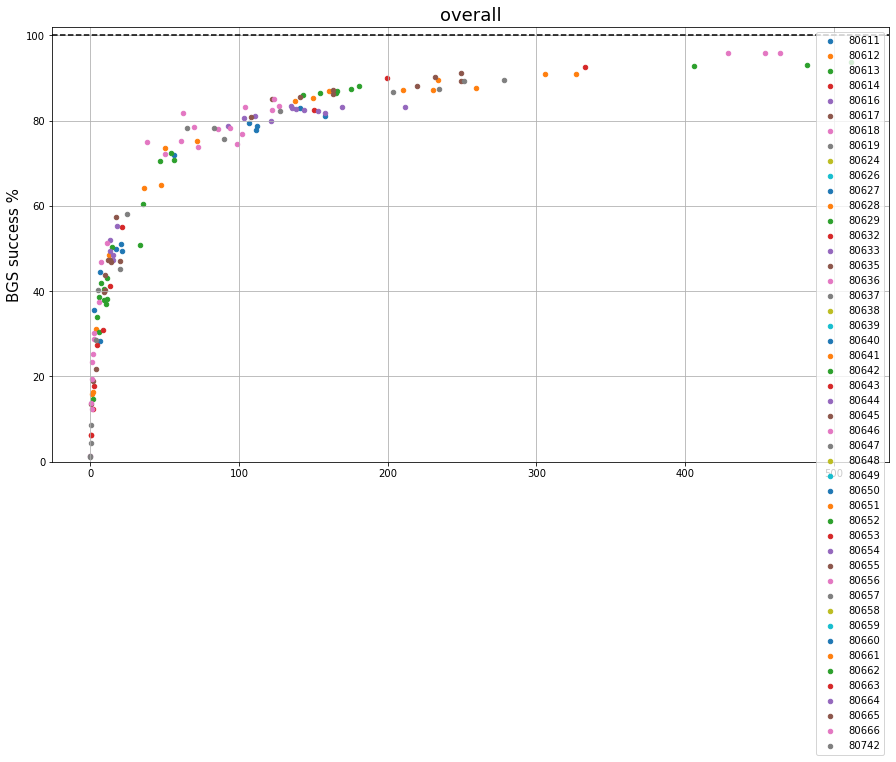

In [17]:
#
fig = plt.figure(figsize=(15,8))

for i, (key, val) in enumerate(dict2.items()):
    
    plt.subplot(1,1,i+1)
    plt.title(key, size=18)
    tiles = np.unique(val['TILEID'])
    x = val[xlab]
    y = np.array([np.float(i) for i in val['BGSSUCCESS_%']])

    for tile in tiles:
        keep = (val['TILEID'] == tile)
        
        plt.scatter(x[keep], y[keep], s=20, label=tile if i == 0 else None)

    if i == 0: plt.legend()
    if i > 2: plt.xlabel(xlab, size=15)
    if i in [0,3]: plt.ylabel('BGS success %', size=15)
    plt.axhline(100, ls='--', c='k')
    if key != 'BGS_LOWQ': 
        plt.ylim(0, 102)
    plt.grid()

In [3]:
#
bgslist = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_EXT', 'BGS_FIBMAG', 'BGS_LOWQ']
badz_list = ['ZWARN', 'DELTACHI2', 'SPECTYPE', 'ZERR']
sing_exp_sv = {}
for i in bgslist:
    
    dexps_i, ids, _ = get_bgs_sv1(summed_depth=False, dX2_lim = 40, bgslist=[i], ID='exposures', badz_list=None, write=False, debug=False)
    sing_exp_sv[i] = dexps_i



68619 	 0 	 (500 	 500)
is None
LOST 13 on FIBER cut
LOST 384 on BGS cut
LOST 10 on Z cut
93


68619 	 1 	 (500 	 500)
is None
LOST 27 on FIBER cut
LOST 381 on BGS cut
LOST 3 on Z cut
182


68619 	 2 	 (500 	 500)
is None
LOST 15 on FIBER cut
LOST 389 on BGS cut
LOST 8 on Z cut
270


68619 	 4 	 (500 	 500)
is None
LOST 26 on FIBER cut
LOST 391 on BGS cut
LOST 8 on Z cut
345


68619 	 5 	 (500 	 500)
is None
LOST 28 on FIBER cut
LOST 341 on BGS cut
LOST 12 on Z cut
464


68619 	 6 	 (500 	 500)
is None
LOST 21 on FIBER cut
LOST 367 on BGS cut
LOST 8 on Z cut
568


68619 	 7 	 (500 	 500)
is None
LOST 34 on FIBER cut
LOST 398 on BGS cut
LOST 1 on Z cut
635


68619 	 8 	 (500 	 500)
is None
LOST 28 on FIBER cut
LOST 381 on BGS cut
LOST 2 on Z cut
724


68619 	 9 	 (500 	 500)
is None
LOST 17 on FIBER cut
LOST 390 on BGS cut
LOST 9 on Z cut
808


68644 	 0 	 (500 	 500)
is None
LOST 22 on FIBER cut
LOST 369 on BGS cut
LOST 6 on Z cut
103


68644 	 1 	 (500 	 500)
is None
LOST 22 on FIBE

In [4]:
#
bgslist = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_EXT', 'BGS_FIBMAG']
dexps_i, _, _ = get_bgs_sv1(summed_depth=False, dX2_lim = 40, bgslist=bgslist, ID='exposures', badz_list=None, write=False, debug=False)
sing_exp_sv['overall'] = dexps_i




68619 	 0 	 (500 	 500)
is None
LOST 51 on FIBER cut
LOST 209 on BGS cut
LOST 50 on Z cut
190


68619 	 1 	 (500 	 500)
is None
LOST 74 on FIBER cut
LOST 177 on BGS cut
LOST 34 on Z cut
405


68619 	 2 	 (500 	 500)
is None
LOST 45 on FIBER cut
LOST 217 on BGS cut
LOST 35 on Z cut
608


68619 	 4 	 (500 	 500)
is None
LOST 65 on FIBER cut
LOST 192 on BGS cut
LOST 35 on Z cut
816


68619 	 5 	 (500 	 500)
is None
LOST 74 on FIBER cut
LOST 141 on BGS cut
LOST 52 on Z cut
1049


68619 	 6 	 (500 	 500)
is None
LOST 59 on FIBER cut
LOST 196 on BGS cut
LOST 52 on Z cut
1242


68619 	 7 	 (500 	 500)
is None
LOST 95 on FIBER cut
LOST 225 on BGS cut
LOST 25 on Z cut
1397


68619 	 8 	 (500 	 500)
is None
LOST 72 on FIBER cut
LOST 183 on BGS cut
LOST 37 on Z cut
1605


68619 	 9 	 (500 	 500)
is None
LOST 43 on FIBER cut
LOST 196 on BGS cut
LOST 53 on Z cut
1813


68644 	 0 	 (500 	 500)
is None
LOST 50 on FIBER cut
LOST 175 on BGS cut
LOST 56 on Z cut
219


68644 	 1 	 (500 	 500)
is None
L

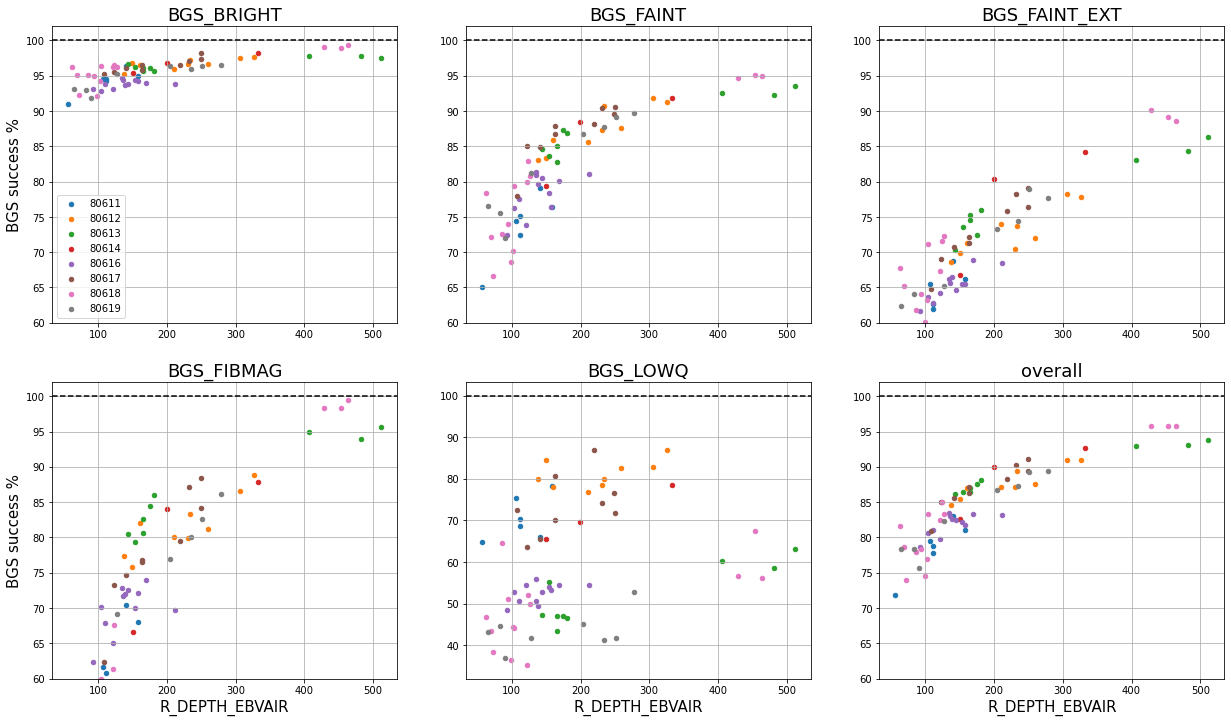

In [5]:
fig = plt.figure(figsize=(21,12))
figs_path = '/global/homes/q/qmxp55/DESI/bgs-cmxsv/figs'
xlab = 'R_DEPTH_EBVAIR'
#xlab = 'R_DEPTH'
file = os.path.join(figs_path, 'bgs_success_%s_zrange2' %(xlab))

for i, (key, val) in enumerate(sing_exp_sv.items()):
    
    plt.subplot(2,3,i+1)
    plt.title(key, size=18)
    tiles = np.unique(val['TILEID'])
    x = val[xlab]
    y = np.array([np.float(i) for i in val['BGSSUCCESS_%']])

    for tile in tiles:
        keep = (val['TILEID'] == tile)
        
        plt.scatter(x[keep], y[keep], s=20, label=tile if i == 0 else None)

    if i == 0: plt.legend()
    if i > 2: plt.xlabel(xlab, size=15)
    if i in [0,3]: plt.ylabel('BGS success %', size=15)
    plt.axhline(100, ls='--', c='k')
    if key != 'BGS_LOWQ': 
        plt.ylim(60, 102)
    plt.grid()
    
if file is not None:
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0.2)

In [6]:
dexps_i

TILEID,EXPID,TILERA,TILEDEC,EXPTIME,B_DEPTH,R_DEPTH,Z_DEPTH,B_DEPTH_EBVAIR,R_DEPTH_EBVAIR,Z_DEPTH_EBVAIR,NBGSA,NBGSW,NBGSZ,ZWARN,DELTACHI2,SPECTYPE,ZRANGE,ZERR,BGSSUCCESS_%
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,str5
80617,68619,5.0,28.0,300.0,243.3,262.9,317.1,184.18425,219.4316,286.78424,2764,2055,1813,114,320,41,125,0,88.22
80617,69026,5.0,28.0,300.0,110.7,192.2,302.8,87.1009,163.49907,276.84927,3065,2272,1961,158,400,43,146,0,86.31
80617,69027,5.0,28.0,300.0,83.6,144.3,224.5,65.43977,122.44068,204.96147,3065,2242,1906,154,425,38,141,0,85.01
80617,69028,5.0,28.0,300.0,74.4,127.9,196.9,57.898563,108.21293,179.46716,3065,2256,1826,207,539,39,157,0,80.94
80611,69031,35.22,30.3,300.0,93.2,154.8,237.1,54.540684,106.8627,193.18352,3191,2321,1844,188,562,74,150,0,79.45
80611,69033,35.22,30.3,300.0,99.3,162.0,244.3,58.04897,111.77483,198.99052,3191,2351,1829,188,616,73,164,0,77.80
80611,69034,35.22,30.3,300.0,124.9,204.4,308.6,72.9131,140.93326,251.26674,3191,2353,1953,153,477,73,152,0,83.00
80611,69035,35.22,30.3,300.0,97.2,162.3,247.9,56.63402,111.79993,201.73486,3191,2343,1847,168,579,75,156,0,78.83
80618,69048,114.221,38.469,300.0,90.0,112.5,137.4,59.689705,85.868484,118.260254,2778,1937,1510,205,548,78,173,0,77.96


# Deep exposures

In [3]:
#
bgslist = ['BGS_BRIGHT', 'BGS_FAINT', 'BGS_FAINT_EXT', 'BGS_FIBMAG', 'BGS_LOWQ']
badz_list   = ['ZWARN', 'ZRANGE','ZERR']
dexps, ids, deep_cache = get_bgs_sv1(summed_depth=True, bgslist=bgslist, ID='tiles', badz_list=badz_list, write=False, debug=False)



80611 	 0 	 (500 	 3000)
is Not None
LOST 31 on FIBER cut
LOST 155 on BGS cut
LOST 17 on Z cut
297


80611 	 1 	 (500 	 3000)
is Not None
LOST 69 on FIBER cut
LOST 169 on BGS cut
LOST 16 on Z cut
543


80611 	 2 	 (500 	 3000)
is Not None
LOST 40 on FIBER cut
LOST 161 on BGS cut
LOST 18 on Z cut
824


80611 	 3 	 (500 	 3000)
is Not None
LOST 83 on FIBER cut
LOST 176 on BGS cut
LOST 22 on Z cut
1043


80611 	 4 	 (500 	 3000)
is Not None
LOST 56 on FIBER cut
LOST 184 on BGS cut
LOST 20 on Z cut
1283


80611 	 5 	 (500 	 3000)
is Not None
LOST 40 on FIBER cut
LOST 217 on BGS cut
LOST 13 on Z cut
1513


80611 	 6 	 (500 	 3000)
is Not None
LOST 29 on FIBER cut
LOST 192 on BGS cut
LOST 18 on Z cut
1774


80611 	 7 	 (500 	 3000)
is Not None
LOST 88 on FIBER cut
LOST 186 on BGS cut
LOST 12 on Z cut
1988


80611 	 8 	 (500 	 3000)
is Not None
LOST 46 on FIBER cut
LOST 169 on BGS cut
LOST 7 on Z cut
2266


80611 	 9 	 (500 	 3000)
is Not None
LOST 49 on FIBER cut
LOST 172 on BGS cut
LOST 2

In [4]:
dexps

TILEID,EXPID,EXPTIME,B_DEPTH,R_DEPTH,Z_DEPTH,B_DEPTH_EBVAIR,R_DEPTH_EBVAIR,Z_DEPTH_EBVAIR,TILERA,TILEDEC,NBGSA,NBGSW,NBGSZ,ZWARN,DELTACHI2,SPECTYPE,ZRANGE,ZERR,BGSSUCCESS_%
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,str6
80614,206055,900.0,889.3,859.2,933.80005,621.7826,682.74255,821.5768,154.1,-1.375,3259,2288,2326,38,0,0,72,0,101.66
80611,414558,1800.0,577.5,996.1,1533.4,335.93344,685.4524,1247.0557,35.22,30.3,3219,2524,2524,39,0,0,141,0,100.00
80619,551896,2400.0,2263.7002,1940.3,2059.2,1306.9315,1333.5562,1659.989,144.0,65.0,3084,2410,2377,112,0,0,173,0,98.63
80612,620074,2700.0,2004.9001,2543.9001,3119.9,1395.4203,2014.9243,2734.1248,66.68,-5.24,3279,2638,2656,26,0,0,81,0,100.68
80613,621339,2700.0,2536.2002,3186.7998,4024.1,1639.7384,2384.144,3409.9263,106.74,56.1,3279,2383,2430,58,0,0,277,0,101.97
80617,620149,2700.0,1274.7,1943.1,2779.4001,995.718,1648.7178,2537.995,5.0,28.0,3087,2470,2470,20,0,0,124,0,100.00
80616,827105,3600.0,1688.2999,2674.4001,3720.2,853.7682,1672.894,2870.0776,356.0,29.0,3288,2512,2486,94,0,0,230,0,98.96
80618,967612,4200.0,2505.0,3144.1,3852.3997,1694.5728,2408.2825,3312.784,114.221,38.469,3150,2359,2408,43,0,0,169,0,102.08


In [5]:
cat = np.concatenate(tuple(deep_cache.values()))
print(len(cat))

19677


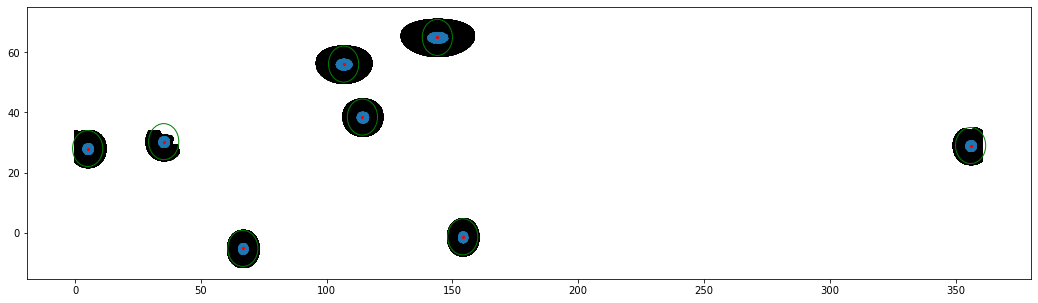

In [49]:
#
fig, ax = plt.subplots(figsize=(18, 5))

for i in dexps:
    circle1 = plt.Circle((i['TILERA'], i['TILEDEC']), 6, fill=None, fc=None, ec='g')
    ax.add_patch(circle1)
    
plt.scatter(masters['RA'], masters['DEC'], s=1, color='k')
plt.scatter(cat['TARGET_RA'], cat['TARGET_DEC'], s=1)
plt.scatter(dexps['TILERA'], dexps['TILEDEC'], s=5, color='r')


In [52]:
def get_sets(df=None, colname='SV1_BGS_TARGET'):
    
    sets = {}
    
    sets['bright'] = (df[colname] & sv1_bgs_mask['BGS_BRIGHT']) != 0
    sets['faint'] = (df[colname] & sv1_bgs_mask['BGS_FAINT']) != 0
    sets['faint_ext'] = (df[colname] & sv1_bgs_mask['BGS_FAINT_EXT']) != 0
    sets['fibmag'] = (df[colname] & sv1_bgs_mask['BGS_FIBMAG']) != 0
    sets['lowq'] = (df[colname] & sv1_bgs_mask['BGS_LOWQ']) != 0
    sets['overall'] = ((sets['bright']) | (sets['faint']) | (sets['faint_ext']) | (sets['fibmag']))
    
    #sanity check
#     tot = len(df)
#     for key, val in sets.items():
#         print('%s: \t %.1f' %(key, 100 * np.sum(val) / tot))
        
    return sets

In [75]:
#
import pandas as pd

def get_spectype(df, sets=None, tot=None):
    
    spec = set(df['SPECTYPE'])
    specs = {}
    sets_spec = {i:[] for i in spec}
    if sets is None:
        sets = get_sets(df)
    zlimit = 200/(3*10**(5))
    #tot = len(zbest)

    for key, val in sets_spec.items():
        #print(key)

        if key == 'GALAXY':
            specs[key] = (df['SPECTYPE'] == key) & (df['Z'] > zlimit)
            badspec = (df['SPECTYPE'] == key) & (df['Z'] < zlimit)
            tot_g = np.sum(df['SPECTYPE'] == key)
            print('frac. Spec. Galaxies with z < 200 k/s: \t %.2f %%' %(100 * np.sum(badspec) / tot_g))
        if key == 'STAR':
            specs[key] = (df['SPECTYPE'] == key) | ((df['SPECTYPE'] == 'GALAXY') & (df['Z'] < zlimit))
        else:
            specs[key] = (df['SPECTYPE'] == key) #& (df['Z'] > zlimit)

        for key2, val2 in sets.items():

            if tot is None:
                toti = np.sum((val2))
            else:
                toti = tot
            dd = 100 * np.sum((val2) & (specs[key])) / toti
            #print(key, ley2, dd)
            sets_spec[key].append(np.round(dd,1))

    tab = pd.DataFrame.from_dict(sets_spec, orient='index', columns=[i for i in sets.keys()])

    return tab, specs


In [56]:
#contamination
def mw_xtinct(ebv, band):
    # https://www.legacysurvey.org/dr9/catalogs/
    # https://arxiv.org/pdf/1012.4804.pdf
    coeffs = {'G': 3.214, 'R': 2.165, 'i': 1.592, 'Z': 1.211, 'Y': 1.064}

    Ab     = coeffs[band] * ebv

    return  10.**(-Ab / 2.5) 

def get_cont(df, spectype):
    
    rbins = np.linspace(13, 21, 14)
    res = []
    delta = np.abs(rbins[1] - rbins[0])/2
    
    # convert r-band flux to magnitude
    rmag = 22.5 - 2.5 * np.log10(df['FLUX_R']/mw_xtinct(df['EBV'], 'R'))

    for i in range(len(rbins[:-1])):

        keep = (rmag > rbins[i]) & (rmag < rbins[i+1]) #& (specs['STAR'])
        cumu = rmag < rbins[i+1] #& (specs['STAR'])
        rmid = rbins[i] + delta
        
        #err= np.std(res[1])/np.sqrt(len(res[1]))
        
        a = np.sum((keep) & (spectype)) / np.sum(keep)
        b = np.sum((cumu) & (spectype)) / np.sum(cumu)
        erra = np.std(rmag[(keep) & (spectype)])/np.sqrt(len(rmag[(keep) & (spectype)]))

        res.append([rmid, a, b, erra])

    return np.transpose(res)

### Match sv1 target catalogue with spectra data

In [6]:
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask

In [45]:
cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                    'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                        'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                            'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                                 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'MORPHTYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                       'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 
                                            'SV1_MWS_TARGET', 'HPXPIXEL', 'PHOTSYS', 'TARGETID', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3',
                                                 'FLUX_W4', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4']

#
hpdirname = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.47.0/targets/sv1/resolve/bright'

#use this to check the properties of the hp directory
#nside, pixdict = check_hp_target_dir(hpdirname)

#Load full DR9 target catalogue
#%time mastertargs = read_targets_in_hp(hpdirname=hpdirname, nside=nside, pixlist=np.array(list(pixdict.keys())), columns=cols)

# Read targets in an RA, Dec, radius (degrees) "circle"
captargs = {}
for key in dexps:
    rai, deci = key['TILERA'], key['TILEDEC']
    radecrad = [rai,deci,6]
    #print(radecrad, type(str(key['TILEID'])))
    captargs[str(key['TILEID'])] = read_targets_in_cap(hpdirname, radecrad)


In [46]:
#
masters = np.concatenate(tuple(captargs.values()))

In [48]:
#
print('Total bright targets: \t %i' %(masters.size))

#DESI target classes
clases = {}
clases['ELG'] = (masters["SV1_DESI_TARGET"] & desi_mask["ELG"]) != 0
clases['LRG'] = (masters["SV1_DESI_TARGET"] & desi_mask["LRG"]) != 0
clases['QSO'] = (masters["SV1_DESI_TARGET"] & desi_mask["QSO"]) != 0
clases['BGS'] = (masters["SV1_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0

for key, val in clases.items():
    print(key, np.sum(val))

Total bright targets: 	 4669429
ELG 17887
LRG 377582
QSO 27634
BGS 2135186


In [50]:
# mastertargs = mastertargs[clases['BGS']]
# masters = Table(mastertargs)
# del mastertargs

cat1 = join(cat, masters, keys='TARGETID', join_type='left')

bright 8040 8040
faint 5844 5844
faint_ext 3984 3984
fibmag 1692 1692


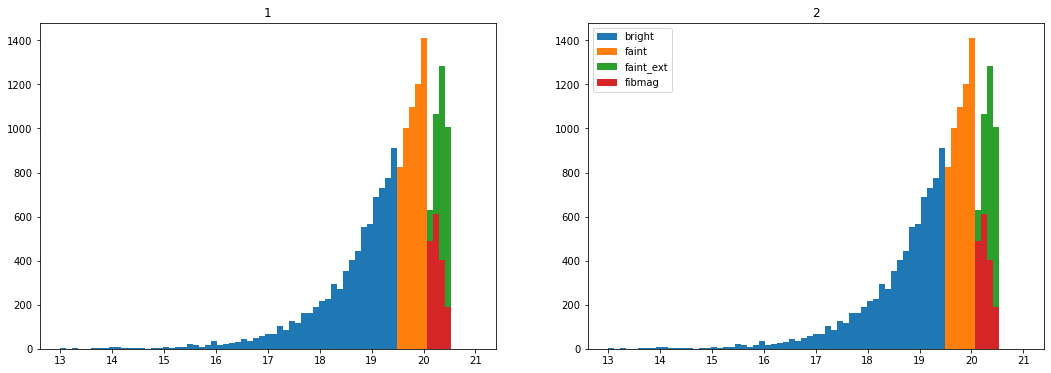

In [59]:
# sanity check of matched catalogues
sets1 = get_sets(df=cat1, colname='SV1_BGS_TARGET_1')
sets2 = get_sets(df=cat1, colname='SV1_BGS_TARGET_2')

#gmag = 22.5 - 2.5 * np.log10(cat['FLUX_G']/mw_xtinct(cat['EBV'], 'G'))
rmag1 = 22.5 - 2.5 * np.log10(cat1['FLUX_R_1']/mw_xtinct(cat1['EBV_1'], 'R'))
rmag2 = 22.5 - 2.5 * np.log10(cat1['FLUX_R_2']/mw_xtinct(cat1['EBV_2'], 'R'))
#zmag = 22.5 - 2.5 * np.log10(cat['FLUX_Z']/mw_xtinct(cat['EBV'], 'Z'))

rbin = np.linspace(13,21,70)
fig = plt.figure(figsize=(18,6))

for key in ['bright', 'faint', 'faint_ext', 'fibmag']:
    
    print(key, np.sum(sets1[key]), np.sum(sets2[key]))
    
    plt.subplot(1,2,1)
    plt.title('1')
    plt.hist(rmag1[sets1[key]], rbin, label=key)
    
    plt.subplot(1,2,2)
    plt.title('2')
    plt.hist(rmag2[sets2[key]], rbin, label=key)

plt.legend()    
plt.show()
    

In [63]:
#delete repeated columns from the master targets sv1 catalogue

cat1 = Table(cat)
masters = Table(masters)

for i in cat.dtype.names:
    if i in masters.dtype.names:
        if i == 'TARGETID': continue
        
        del masters[i]
        print(i, 'deleted')
        
#merge catalogues
cat = join(cat1, masters, keys='TARGETID', join_type='left')

# get bgs super sets
sets = get_sets(df=cat)

#save table
cat.write('/global/homes/q/qmxp55/DESI/bgs-cmxsv/py/bgs_sv/dat/bgs_deep.fits')
#df = Table.read('/global/homes/q/qmxp55/DESI/bgs-cmxsv/py/bgs_sv/dat/bgs_deep.fits')

# get bgs cuts
geocuts = getGeoCuts(np.array(cat), survey='sv')
photcuts = getPhotCuts(np.array(cat), mycat=False, survey='sv')
bgscuts = geocuts
bgscuts.update(photcuts)

# check bgs cuts
for key, val in bgscuts.items():
    print(key, np.sum(~val))
    

RELEASE deleted
BRICKID deleted
BRICKNAME deleted
BRICK_OBJID deleted
RA deleted
RA_IVAR deleted
DEC deleted
DEC_IVAR deleted
DCHISQ deleted
FLUX_IVAR_G deleted
FLUX_IVAR_R deleted
FLUX_IVAR_Z deleted
MW_TRANSMISSION_G deleted
MW_TRANSMISSION_R deleted
MW_TRANSMISSION_Z deleted
FRACFLUX_G deleted
FRACFLUX_R deleted
FRACFLUX_Z deleted
FRACMASKED_G deleted
FRACMASKED_R deleted
FRACMASKED_Z deleted
FRACIN_G deleted
FRACIN_R deleted
FRACIN_Z deleted
NOBS_G deleted
NOBS_R deleted
NOBS_Z deleted
PSFDEPTH_G deleted
PSFDEPTH_R deleted
PSFDEPTH_Z deleted
GALDEPTH_G deleted
GALDEPTH_R deleted
GALDEPTH_Z deleted
FLUX_W1 deleted
FLUX_W2 deleted
FLUX_W3 deleted
FLUX_W4 deleted
FLUX_IVAR_W1 deleted
FLUX_IVAR_W2 deleted
FLUX_IVAR_W3 deleted
FLUX_IVAR_W4 deleted
MW_TRANSMISSION_W1 deleted
MW_TRANSMISSION_W2 deleted
MW_TRANSMISSION_W3 deleted
MW_TRANSMISSION_W4 deleted
ALLMASK_G deleted
ALLMASK_R deleted
ALLMASK_Z deleted
FIBERTOTFLUX_G deleted
FIBERTOTFLUX_R deleted
FIBERTOTFLUX_Z deleted
REF_EPOCH de

## Overall results

In [67]:
set(cat['SPECTYPE'])

{'GALAXY', 'QSO', 'STAR'}

In [73]:
#
mask = (cat['DELTACHI2'] > 40)
tab, _ = get_spectype(cat[mask], tot=None)
tab

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,97.4,98.4,99.2,95.1,73.9,97.8
QSO,1.0,0.6,0.6,1.7,0.2,0.9
STAR,1.7,1.1,0.3,3.3,28.8,1.4


In [76]:

tab, _ = get_spectype(cat[mask], tot=np.sum(mask))
tab

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.7,0.3,0.1,0.3,0.7,1.3


In [213]:
#
def rmag_plot(df=None, masks=None):
    
    ckey = {'STAR':'r', 'GALAXY':'b', 'QSO':'green'}
    _, specs = get_spectype(df)
    sets = get_sets(df)
    markers = ['-', '--', ':', '-.']
    delta = np.linspace(0.4, 0.6, len(masks.keys()))
    for num, (key1, keep) in enumerate(masks.items()):
        for key, val in specs.items():

            #keep = (cat['DELTACHI2'] > 40) & sets['overall']
            #keep2 = (cat['DELTACHI2'] > 100) & sets['overall']
            res = get_cont(df=df[keep], spectype=val[keep])
            #res_chi2_20 = get_cont(df=cat[keep2], spectype=val[keep2])

            plt.errorbar(res[0], res[1], res[3], marker='*', ls=markers[num] ,c=ckey[key], label=key if num == 0 else None)
            #plt.errorbar(res_chi2_20[0], res_chi2_20[1], res_chi2_20[3], marker='*', ls='--', c=ckey[key], label=key)

            #plt.plot(res_chi2_20[0], res_chi2_20[1], marker='*', ls='--', c=ckey[key])
            #plt.plot(res[0], res[2], marker='o', c=ckey[key])

        plt.text(17.0, delta[num], '%s %s' %(markers[num], key1), size=12)

    plt.axhline(1, ls='--', c='k')
    plt.xlabel(r'r-mag', size=20)
    plt.legend()
    plt.grid()
    plt.show()
    

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


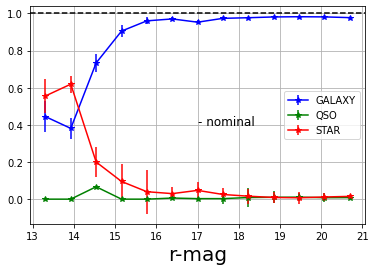

In [214]:
#
masks = {'nominal': (cat['DELTACHI2'] > 40) & sets['overall']}
rmag_plot(df=cat, masks=masks)

frac. Spec. Galaxies with z < 200 k/s: 	 0.00 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.15 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.34 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.09 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.04 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.00 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.17 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.13 %


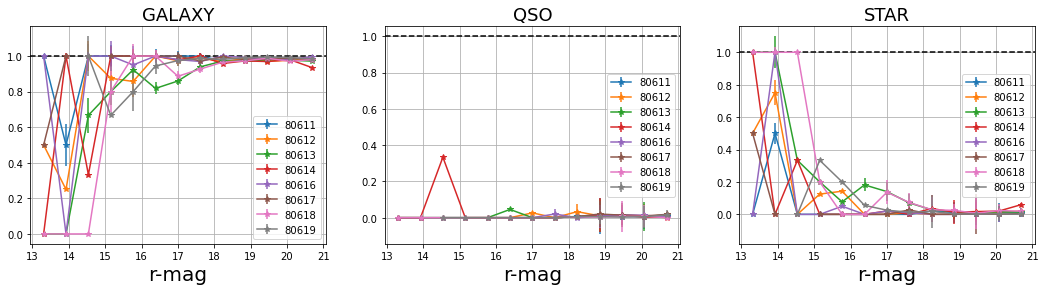

In [78]:
plt.figure(figsize=(18, 4))
#ckey = {'STAR':'r', 'GALAXY':'b', 'QSO':'green'}

for key, val in deep_cache.items():
    deep_cache
    _, specs = get_spectype(val)
    sets = get_sets(val)
    
    for num, key2, val2 in zip(range(3), specs.keys(), specs.values()):
    
        keep = (val['DELTACHI2'] > 40) & sets['overall']
        res = get_cont(df=val[keep], spectype=val2[keep])
        #res_chi2_20 = get_cont(df=val[(val['DELTACHI2'] > 100)], spectype=val2[(val['DELTACHI2'] > 100)])

        plt.subplot(1,3,num+1)
        plt.errorbar(res[0], res[1], res[3], marker='*', label=key)
        #plt.plot(res_chi2_20[0], res_chi2_20[1], marker='*', ls='--', c=ckey[key2])
        
    
ckeys = list(specs.keys())

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(ckeys[i], size=18)
    plt.axhline(1, ls='--', c='k')
    plt.xlabel(r'r-mag', size=20)
    plt.legend()
    plt.grid()

## STAR GALAXY CLASSIFICATION

In [79]:
#
def get_galaxies(gaiagmag, fluxr):
    
    Grr = gaiagmag - 22.5 + 2.5*np.log10(fluxr)
    GAIA_GAL = np.ones_like(gaiagmag, dtype='?')
    GAIA_GAL &= (Grr  >  0.6) | (gaiagmag == 0)
    
    return GAIA_GAL

def get_galaxies_sv(gaiagmag, fluxr, psflike):
    
    Grr = gaiagmag - 22.5 + 2.5*np.log10(fluxr)
    GAIA_GAL = np.ones_like(gaiagmag, dtype='?')
    GAIA_GAL &= ((Grr  >  0.6) | (gaiagmag == 0)) | ((Grr < 0.6) & (~psflike) & (gaiagmag != 0))
    
    return GAIA_GAL

In [80]:
#
psftype = cat['MORPHTYPE']
fluxr = cat['FLUX_R']
gaiagmag = cat['GAIA_PHOT_G_MEAN_MAG']
ingaia = (gaiagmag != 0)
psflike = ((psftype == 'PSF') | (psftype == b'PSF') | (psftype == 'PSF ') | (psftype == b'PSF '))

Ggals = {}

Ggals['out'] = ~ingaia
Ggals['in_main'] = (get_galaxies(gaiagmag, fluxr)) & (ingaia)
Ggals['in_sv'] = (get_galaxies_sv(gaiagmag, fluxr, psflike)) & (ingaia) & (~(get_galaxies(gaiagmag, fluxr)))

totG = np.sum(gaiagmag != 0)
tot = len(cat)

print('total in GAIA: \t %i' %(totG))
print('total: \t %i' %(tot))
print('------')

for key, val in Ggals.items():
    
    print('%s: \t %.1f' %(key, 100 * np.sum(val) / tot))
    

total in GAIA: 	 1074
total: 	 19677
------
out: 	 94.5
in_main: 	 4.8
in_sv: 	 0.7


frac. Spec. Galaxies with z < 200 k/s: 	 5.00 %
frac. Spec. Galaxies with z < 200 k/s: 	 18.18 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.04 %
frac. Spec. Galaxies with z < 200 k/s: 	 0.12 %
frac. Spec. Galaxies with z < 200 k/s: 	 33.33 %


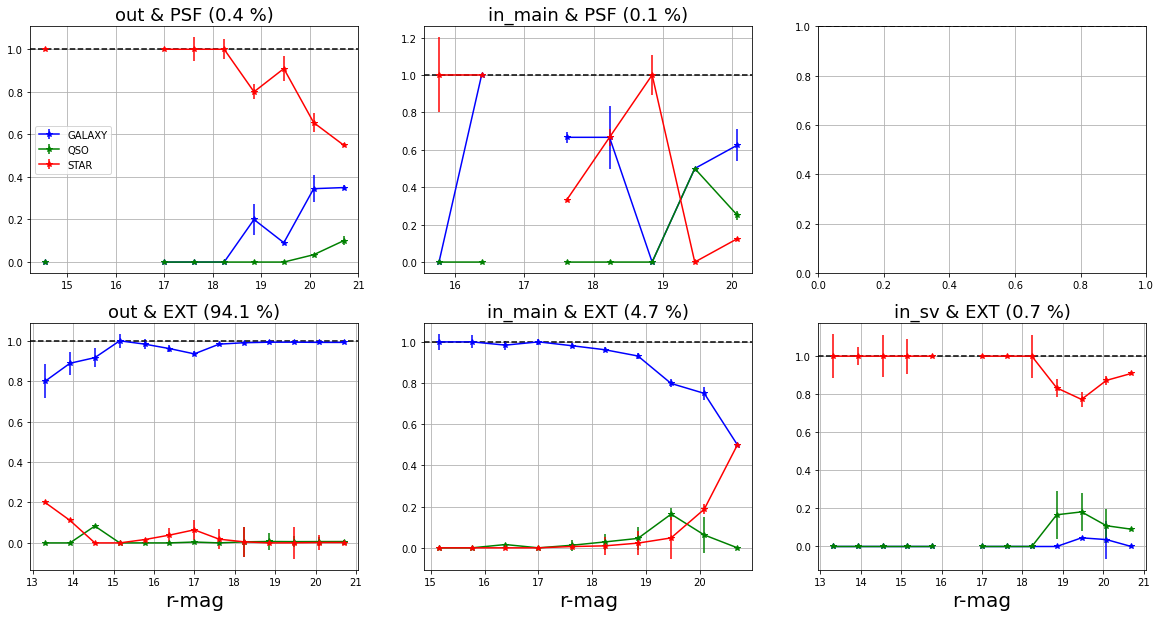

In [81]:
#
plt.figure(figsize=(20, 10))
i = 0
morphs = {'PSF':psflike, 'EXT':~psflike}
sets = get_sets(cat)
tot = np.sum((cat['DELTACHI2'] > 40) & (sets['overall']))

spec = set(cat['SPECTYPE'])
tabs = {}

for lab, morph in morphs.items():
    
    sets_spec = {i:[] for i in spec}
    
    for key, val in Ggals.items():

        #ckey = {b'STAR':'r', b'GALAXY':'b', b'QSO':'green'}
        
        keep = (val) & (morph) & (cat['DELTACHI2'] > 40) & (sets['overall'])
        tab, specs = get_spectype(cat[keep])
        
        for key2, val2 in specs.items():
            
            plt.subplot(2,3, i+1)
            ftot = 100 * np.sum(keep) / tot
            plt.title(r'%s & %s (%.1f %%)' %(key, lab, ftot), size=18)
            res = get_cont(df=cat[keep], spectype=val2)
            plt.errorbar(res[0], res[1], res[3], marker='*', c=ckey[key2], label=key2)
            if i == 0: plt.legend()
                
            #sets_spec[key2].append(ftot * tab['overall'][key2] / 100)
            sets_spec[key2].append(tab['overall'][key2])
            
        i += 1
        
    if lab == 'PSF':
        tabs[lab] = pd.DataFrame.from_dict(sets_spec, orient='index', columns=['out', 'in_main'])
    elif lab == 'EXT':
        tabs[lab] = pd.DataFrame.from_dict(sets_spec, orient='index', columns=[i for i in Ggals.keys()])
            
for i in range(6):
    plt.subplot(2,3,i+1)
    #plt.title(ckeys[i], size=18)
    plt.axhline(1, ls='--', c='k')
    if i > 2: plt.xlabel(r'r-mag', size=20)
    plt.grid()
    

In [82]:
tabs['PSF']

,out,in_main
GALAXY,23.5,50.0
QSO,3.5,13.6
STAR,74.1,45.5


In [83]:
tabs['EXT']

,out,in_main,in_sv
GALAXY,99.1,94.1,2.3
QSO,0.6,3.9,10.1
STAR,0.3,2.1,88.4


### Summarize BGS Vs TRACTOR star-galaxy classification

In [197]:
#

#default = (cat['DELTACHI2'] > 20) & (sets['overall'])

def compare_sg(cat, mask, Ggals, psflike):

    #tot = np.sum(default)
    spec = set(cat['SPECTYPE'])

    bgsC = (~Ggals['in_sv'])
    traC = (~psflike)

    classi = {'agree':(bgsC) & (traC) & (default), 'in BGS': (bgsC) & (~traC) & (default), 'in TRACTOR':(~bgsC) & (traC) & (default)}
    classi_spec = {i:[] for i in spec}
    markers = {'agree':'-', 'in BGS':'--', 'in TRACTOR':':'}
    i = 0
    delta = np.linspace(0.4, 0.6, 3)
    
    # get total
    keep = np.zeros_like(cat['RA'], dtype=bool)
    for key, val in classi.items():
        keep |= val
    tot = np.sum(keep)

    plt.figure(figsize=(8, 6))

    for key, val in classi.items():

        ftot = 100 * np.sum(val) / tot
        tab, specs = get_spectype(cat[val], tot=tot)
        print('fraction %s: \t %.2f' %(key, ftot))
        #plt.subplot(1,3,1)
        print('------- %s ------' %(markers[key]))
        plt.text(13.5, delta[i], '%s %s' %(markers[key], key), size=14)

        for key2, val2 in specs.items():

            #plt.subplot(1,2, i+1)
            res = get_cont(df=cat[val], spectype=val2)
            if key2 != b'QSO':

                #plt.subplot(1,1,1)
                plt.errorbar(res[0], res[1], res[3], ls=markers[key], c=ckey[key2], label=key2)
                if i == 0: plt.legend()
                #plt.yscale('log')

#                 plt.subplot(1,3,2)
#                 plt.errorbar(res[0], res[1], res[3], ls=markers[key], c=ckey[key2])
#                 plt.ylim(0.9,1)
#                 plt.xlim(17,21)

#                 plt.subplot(1,3,3)
#                 plt.errorbar(res[0], res[1], res[3], ls=markers[key], c=ckey[key2])
#                 plt.ylim(0,0.1)
#                 plt.xlim(17,21)


            #sets_spec[key2].append(ftot * tab['overall'][key2] / 100)
            classi_spec[key2].append(tab['overall'][key2])

        i += 1

    tab = pd.DataFrame.from_dict(classi_spec, orient='index', columns=[i for i in classi.keys()])

    for i in range(1):
        plt.subplot(1,1,i+1)
        plt.axhline(1, ls='--', c='k')
        plt.xlabel(r'r-mag', size=18)
        plt.grid()

    return tab
    

### Results for DELTACHI2 > 40 & z > 200 [k/s] / c

frac. Spec. Galaxies with z < 200 k/s: 	 0.05 %
fraction agree: 	 98.78
------- - ------
frac. Spec. Galaxies with z < 200 k/s: 	 9.68 %
fraction in BGS: 	 0.55
------- -- ------
frac. Spec. Galaxies with z < 200 k/s: 	 33.33 %
fraction in TRACTOR: 	 0.67
------- : ------


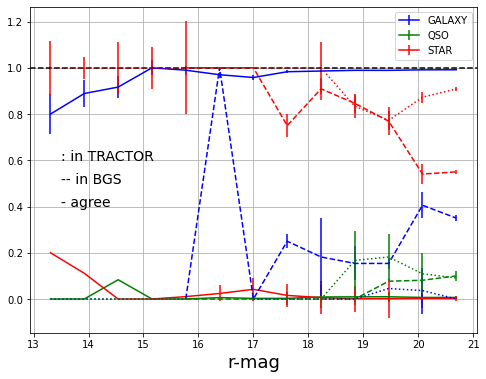

In [198]:
#
default = (cat['DELTACHI2'] > 40) & (sets['overall'])
tab = compare_sg(cat=cat, mask=default, Ggals=Ggals, psflike=psflike)

In [199]:
tab

,agree,in BGS,in TRACTOR
GALAXY,97.7,0.2,0.0
QSO,0.8,0.0,0.1
STAR,0.4,0.4,0.6


In [96]:
#
def plots(cat, coord, mask, psflike, n, fig, gs, title):
    
    ax = plt.subplot(gs[n])
    x, y = list(coord.keys())
    
    #plt.figure(figsize=(6,6))

    morphs = {'EXT':~psflike, 'PSF':psflike}
    tab, specs = get_spectype(cat)
    #ckey = {b'STAR':'r', b'GALAXY':'b', b'QSO':'green'}

    #for lab, morph in morphs.items():
    for key, val in specs.items():

        keep = (mask) & (val)
        print(key, np.sum(keep))
        ax.set_title(title, size=15)
        ax.scatter(coord[x][keep], coord[y][keep], s=1 if np.sum(keep) > 200 else 7, color=ckey[key], label='%s (%i)' %(key, np.sum(keep)))
        ax.legend()

    ax.set_xlabel(x, size=18)
    ax.set_ylabel(y, size=18)
    #ax.set_xlim(-1.5,4.5)
    #ax.set_ylim(-2,4)
    
    return ax


frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 811
QSO 35
STAR 66
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 55
QSO 11
STAR 46
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 0
QSO 0
STAR 2
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 8
QSO 6
STAR 29
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 17
QSO 0
STAR 47
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 874
QSO 52
STAR 143


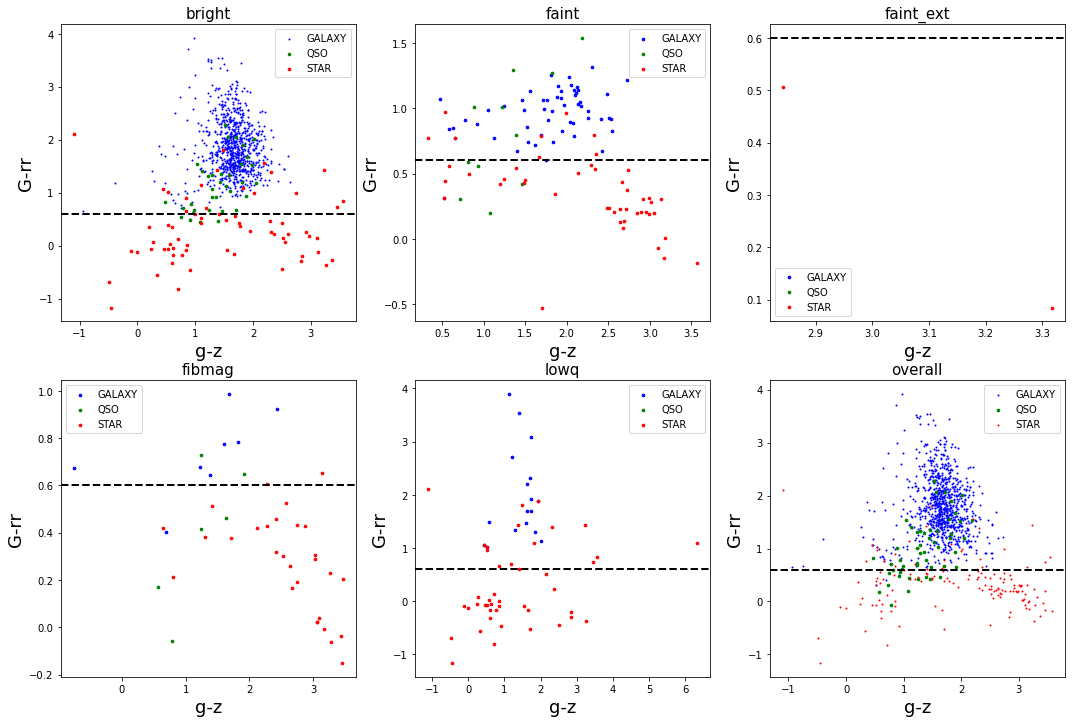

In [88]:
#
from matplotlib import gridspec
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3)

gmag = 22.5 - 2.5 * np.log10(cat['FLUX_G']/mw_xtinct(cat['EBV'], 'G'))
zmag = 22.5 - 2.5 * np.log10(cat['FLUX_Z']/mw_xtinct(cat['EBV'], 'Z'))
#rmag = 22.5 - 2.5 * np.log10(df['FLUX_R']/mw_xtinct(df['EBV'], 'R'))

coord = {'g-z': gmag - zmag,
         'G-rr': gaiagmag - 22.5 + 2.5*np.log10(fluxr),
         }
i = 0

for key, val in sets.items():
    #plt.subplot(2,3,i+1)
    mask = (ingaia) & (cat['DELTACHI2'] > 40) & (sets[key])
    ax = plots(cat, coord, mask, psflike, i, fig, gs, key)
    ax.axhline(0.6, ls='--', lw=2, c='k')
    i += 1
    

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 7794
QSO 82
STAR 133
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 5693
QSO 33
STAR 62
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 3876
QSO 24
STAR 11
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 1599
QSO 29
STAR 56
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 334
QSO 1
STAR 130
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 18962
QSO 168
STAR 262


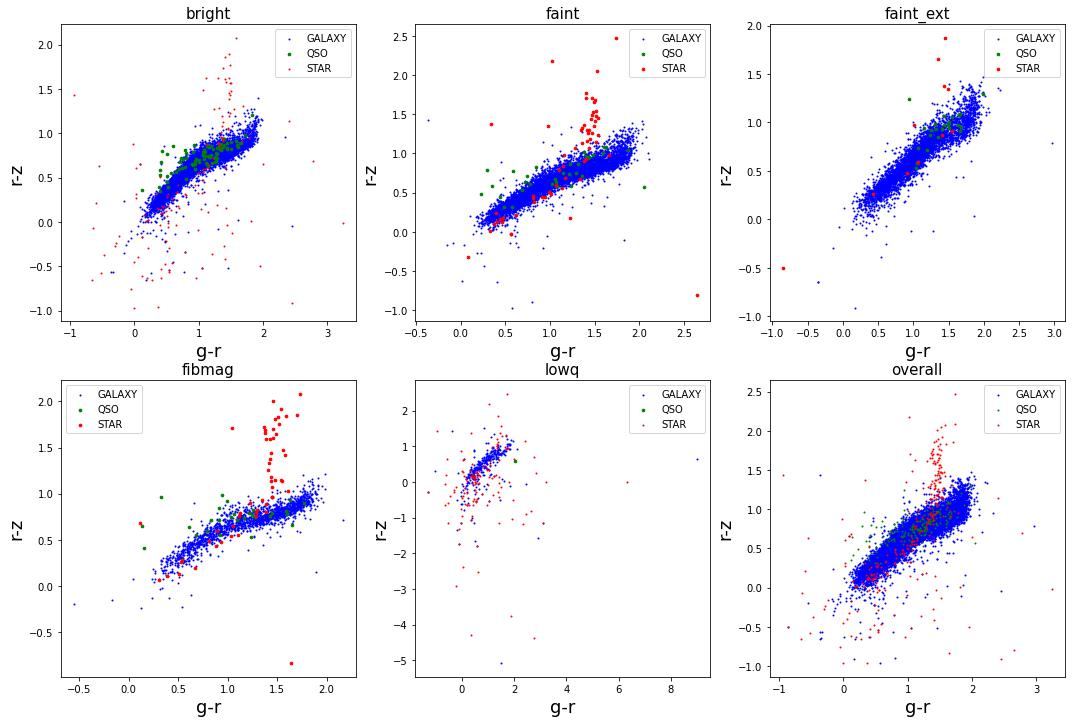

In [89]:
#
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3)

gmag = 22.5 - 2.5 * np.log10(cat['FLUX_G']/mw_xtinct(cat['EBV'], 'G'))
rmag = 22.5 - 2.5 * np.log10(cat['FLUX_R']/mw_xtinct(cat['EBV'], 'R'))
zmag = 22.5 - 2.5 * np.log10(cat['FLUX_Z']/mw_xtinct(cat['EBV'], 'Z'))

coord = {'g-r': gmag - rmag,
         'r-z': rmag - zmag,
         }
i = 0

for key, val in sets.items():
    #plt.subplot(2,3,i+1)
    mask = (cat['DELTACHI2'] > 40) & (sets[key])
    ax = plots(cat, coord, mask, psflike, i, fig, gs, key)
    i += 1
    

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 811
QSO 35
STAR 66
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 55
QSO 11
STAR 46
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 0
QSO 0
STAR 2
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 8
QSO 6
STAR 29
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 17
QSO 0
STAR 47
frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %
GALAXY 874
QSO 52
STAR 143


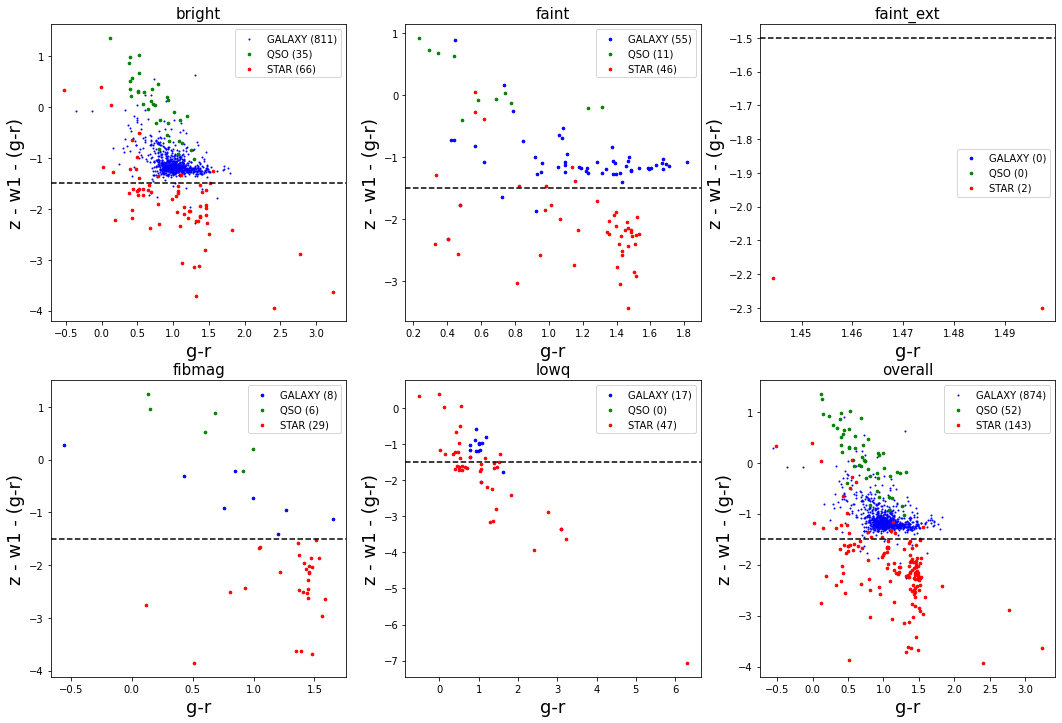

In [267]:
#
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2,3)

gmag = 22.5 - 2.5 * np.log10(cat['FLUX_G']/mw_xtinct(cat['EBV'], 'G'))
rmag = 22.5 - 2.5 * np.log10(cat['FLUX_R']/mw_xtinct(cat['EBV'], 'R'))
zmag = 22.5 - 2.5 * np.log10(cat['FLUX_Z']/mw_xtinct(cat['EBV'], 'Z'))
w1mag = 22.5 - 2.5 * np.log10(cat['FLUX_W1']/cat['MW_TRANSMISSION_W1'])
w2mag = 22.5 - 2.5 * np.log10(cat['FLUX_W2']/cat['MW_TRANSMISSION_W2'])
w3mag = 22.5 - 2.5 * np.log10(cat['FLUX_W3']/cat['MW_TRANSMISSION_W3'])
w4mag = 22.5 - 2.5 * np.log10(cat['FLUX_W4']/cat['MW_TRANSMISSION_W4'])

#
#
#'G-rr': gaiagmag - 22.5 + 2.5*np.log10(fluxr)
coord = {'g-r': gmag - rmag,
         'z - w1 - (g-r)': -1*(gmag - rmag) + (zmag - w1mag),
         }
i = 0

for key, val in sets.items():
    #plt.subplot(2,3,i+1)
    mask = (cat['DELTACHI2'] > 40) & (sets[key]) & (ingaia) #& (rmag < 19)
    ax = plots(cat, coord, mask, psflike, i, fig, gs, key)
    ax.axhline(-1.5, ls='--', color='k')
    i += 1

In [247]:
#
mask1 = (cat['DELTACHI2'] > 40)
tab0, _ = get_spectype(cat[mask1], tot=np.sum(mask1))
tab0

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.7,0.3,0.1,0.3,0.7,1.3


In [232]:
#
mask = (cat['DELTACHI2'] > 40) & ~(((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia))
tab1, _ = get_spectype(cat[mask], tot=np.sum(mask1))
tab1

frac. Spec. Galaxies with z < 200 k/s: 	 0.08 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.4,0.1,0.0,0.1,0.5,0.7


In [233]:

#
mask = (cat['DELTACHI2'] > 40) & (~Ggals['in_sv']) & ~(((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia))
tab2, _ = get_spectype(cat[mask], tot=np.sum(mask1))
tab2

frac. Spec. Galaxies with z < 200 k/s: 	 0.08 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.1,0.1,0.1,0.0,0.8
STAR,0.4,0.1,0.0,0.1,0.5,0.6


frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


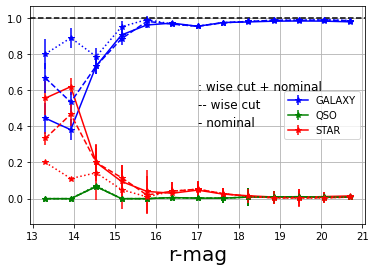

In [216]:
#
masks = {'nominal': (cat['DELTACHI2'] > 40) & sets['overall'], 
         'wise cut': (cat['DELTACHI2'] > 40) & ~(((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia)),
         'wise cut + nominal': (cat['DELTACHI2'] > 40) & (~Ggals['in_sv']) & ~(((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia))}
rmag_plot(df=cat, masks=masks)

## Quality Cuts

``` python
nobs = (df['NOBS_G'] > 0) & (df['NOBS_R'] > 0) & (df['NOBS_Z'] > 0)

cc_gr = np.logical_and((gmag - rmag) > -1, (gmag - rmag) < 4)
cc_rz = np.logical_and((rmag - zmag) > -1, (rmag - zmag) < 4)

QC_FM &= (df['FRACMASKED_R'] < 0.4)
QC_FM &= (df['FRACMASKED_G'] < 0.4)
QC_FM &= (df['FRACMASKED_Z'] < 0.4)

QC_FI &= (df['FRACIN_R'] > 0.3) 
QC_FI &= (df['FRACIN_G'] > 0.3) 
QC_FI &= (df['FRACIN_Z'] > 0.3) 

QC_FF &= (df['FRACFLUX_R'] < 5.) 
QC_FF &= (df['FRACFLUX_G'] < 5.)  
QC_FF &= (df['FRACFLUX_Z'] < 5.) 
```

In [220]:
# get the lowq cuts in sv
#bgslist_WQC = ['nobs', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']

def get_rej_sv(df=None, cuts=None):
    
    bgs_sv_lowq = np.zeros_like(df['RA'], dtype='?')

    for key in cuts:
        if key != 'SGSV': 
            keep = ((bgscuts['SGSV']) & (bgscuts['BS']) & (bgscuts['GC']) & (~bgscuts[key]))
            #print(key, np.sum(keep))
            bgs_sv_lowq |= keep
            
    return bgs_sv_lowq

lowq_i = {}
lowq_i['QC'] = get_rej_sv(df=cat, cuts=['QC_FM', 'QC_FI', 'QC_FF'])
lowq_i['QC2'] = get_rej_sv(df=cat, cuts=['QC_FM2', 'QC_FI2', 'QC_FF2'])
lowq_i['nobs_cc'] = get_rej_sv(df=cat, cuts=['nobs', 'CC'])
lowq_i['all'] = get_rej_sv(df=cat, cuts=['nobs', 'CC', 'QC_FM', 'QC_FI', 'QC_FF'])

for key, val in lowq_i.items():
    print(key, np.sum(val))
        

QC 499
QC2 269
nobs_cc 53
all 503


In [221]:
# check overlap with bgs super sets
for key, val in sets.items():
    keep = (val) & (lowq_i['all'])
    print(key, np.sum(keep))

bright 221
faint 143
faint_ext 38
fibmag 27
lowq 438
overall 429


In [245]:
#[(cat1['DELTACHI2'] > 40)]
sets_tmp = {'QC not NEW_QC':(lowq_i['QC']) & (~lowq_i['QC2']) & (~lowq_i['nobs_cc']),
            'NEW_QC not QC':(lowq_i['QC2']) & (~lowq_i['nobs_cc']),
            'NOBS_CC':(lowq_i['nobs_cc']),
            'ALL': lowq_i['all']}
tab, _ = get_spectype(cat1, sets=sets_tmp, tot=np.sum(sets_tmp['ALL']))
tab

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


,QC not NEW_QC,NEW_QC not QC,NOBS_CC,ALL
GALAXY,39.2,28.4,7.0,74.6
QSO,0.2,0.2,0.0,0.4
STAR,3.0,20.3,5.0,28.2


frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


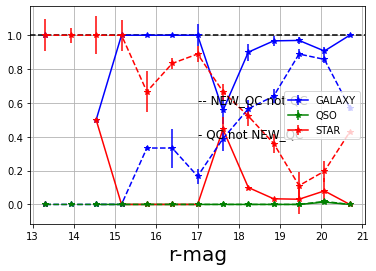

In [226]:
#
masks = {}
for i in ['QC not NEW_QC', 'NEW_QC not QC']:
    masks[i] = sets_tmp[i]
rmag_plot(df=cat, masks=masks)

In [246]:
#[(cat1['DELTACHI2'] > 40)]
sets_tmp = {'QC not NEW_QC':(lowq_i['QC']) & (~lowq_i['QC2']) & (~lowq_i['nobs_cc']),
            'NEW_QC not QC r < 18':(lowq_i['QC2']) & (~lowq_i['nobs_cc']) & (rmag < 18),
            'NEW_QC not QC r > 18':(lowq_i['QC2']) & (~lowq_i['nobs_cc']) & (rmag > 18),
            'NOBS_CC':(lowq_i['nobs_cc']),
            'ALL': lowq_i['all']}
tab, _ = get_spectype(cat1, sets=sets_tmp, tot=np.sum(sets_tmp['ALL']))
tab

frac. Spec. Galaxies with z < 200 k/s: 	 0.11 %


,QC not NEW_QC,NEW_QC not QC r < 18,NEW_QC not QC r > 18,NOBS_CC,ALL
GALAXY,39.2,3.0,25.4,7.0,74.6
QSO,0.2,0.0,0.2,0.0,0.4
STAR,3.0,12.7,7.6,5.0,28.2


### conclusion
Note that in BGS SV selection we do not apply the `QCs` at all as we wanted to have a larger sample to test. This means that results in previous section can be improved even more.

If we decide to move to the `NEW_QCs` mask that means we will recover around 42% of objects of which 39% are spectroscopic Galaxies while only 3% are spectroscopic Stars. For the objects we still reject, we find around 28% of Galaxies and 20% of Stars.

Lets see what overall results look if we apply the `NEW_QCs` mask.

In [252]:
keep = (get_rej_sv(df=cat, cuts=['QC_FM2', 'QC_FI2', 'QC_FF2'])) & (rmag < 18)
np.sum(keep)

94

In [250]:
#
#mask = (cat['DELTACHI2'] > 40) & (~Ggals['in_sv']) & ~(((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia))
mask = (cat['DELTACHI2'] > 40) & ~(get_rej_sv(df=cat, cuts=['QC_FM2', 'QC_FI2', 'QC_FF2']) & (rmag < 18))
tab2, _ = get_spectype(cat[mask], tot=np.sum(mask1))
tab2

frac. Spec. Galaxies with z < 200 k/s: 	 0.06 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,39.9,29.2,19.9,8.2,1.6,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.4,0.3,0.1,0.3,0.3,1.0


In [251]:
tab0

,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.7,0.3,0.1,0.3,0.7,1.3


In [263]:
#
new_cuts = {}
new_cuts['SG nominal'] = (Ggals['in_sv'])
new_cuts['wise'] = (((-1*(gmag - rmag) + (zmag - w1mag)) < -1.5) & (ingaia))
new_cuts['NEW QCs'] = (get_rej_sv(df=cat, cuts=['QC_FM2', 'QC_FI2', 'QC_FF2'])) & (rmag < 18)

keep = np.zeros_like(cat['RA'], dtype=bool)
for key, val in new_cuts.items():
    keep |= val

new_cuts['all'] = keep


In [259]:
!pip install matplotlib-venn

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=32061 sha256=786b0398631301ed41f26154e443824ecfd1d62ac72c7a1fe7ee7df7da14a835
  Stored in directory: /global/u2/q/qmxp55/.cache/pip/wheels/82/e4/64/dd790d424818bc2f59c11471a1eee5dc8cfcd3f8ee8c4812fa
Successfully built matplotlib-venn


In [260]:
#
import matplotlib
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles

def plot_venn3(A, B, C, norm=None, labels=None, file=None, title=None, colors=None):
    '''inputs A, B, C must booleans.'''
    
    A1 = A
    B1 = B
    C1 = C
    AB = (A1) & (B1)
    AC = (A1) & (C1)
    BC = (B1) & (C1)
    ABC = (A1) & (B1) & (C1)
            
    if norm is None: norm, sf = 1, 1
    else: sf = 2
        
    a1 = round((np.sum(A1) - np.sum(AB) - np.sum(AC) + np.sum(ABC))/norm, sf)
    a2 = round((np.sum(B1) - np.sum(AB) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a3 = round((np.sum(AB) - np.sum(ABC))/norm, sf)
    a4 = round((np.sum(C1) - np.sum(AC) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a5 = round((np.sum(AC) - np.sum(ABC))/norm, sf)
    a6 = round((np.sum(BC) - np.sum(ABC))/norm, sf)
    a7 = round(np.sum(ABC)/norm, sf)
        
    if labels is None: labels = ['Group A', 'Group B', 'Group C']
    if colors is None: colors = ['r', 'green', 'royalblue']
        
    fig = plt.figure(figsize=(7,7))
    v=venn3([a1, a2, a3, a4, a5, a6, a7], set_labels = (labels[0], labels[1], labels[2]), set_colors=(colors), alpha = 0.6)
    c=venn3_circles([a1, a2, a3, a4, a5, a6, a7], linestyle='dotted', linewidth=1, color="k")
    
    if title is not None: plt.title(title, size=20)
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

    plt.show()
    

In [261]:
new_cuts.keys()

dict_keys(['SG nominal', 'wise', 'NEW QCs'])

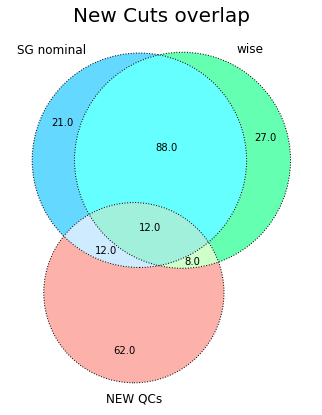

In [262]:
plot_venn3(A=new_cuts['SG nominal'], B=new_cuts['wise'], C=new_cuts['NEW QCs'], norm=None, 
           labels=['SG nominal', 'wise', 'NEW QCs'], file=None, title='New Cuts overlap', colors = ['deepskyblue', 'springgreen', 'salmon'])

In [265]:
#
mask = (cat['DELTACHI2'] > 40) & ~(new_cuts['all'])
tab2, _ = get_spectype(cat[mask], tot=np.sum(mask1))
tab2

frac. Spec. Galaxies with z < 200 k/s: 	 0.05 %


,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,39.9,29.2,19.9,8.2,1.6,97.2
QSO,0.4,0.1,0.1,0.1,0.0,0.8
STAR,0.2,0.1,0.0,0.1,0.2,0.5


In [266]:
tab0

,bright,faint,faint_ext,fibmag,lowq,overall
GALAXY,40.0,29.2,19.9,8.2,1.7,97.3
QSO,0.4,0.2,0.1,0.1,0.0,0.9
STAR,0.7,0.3,0.1,0.3,0.7,1.3
